In [1]:
#all imports
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
from ProjectFunctions import *
import datetime
import wbdata
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
idx = pd.IndexSlice  #magically make MultiIndex slicing better
#e.g. to set value of Aruba->Afghanistan in 1995 to 42, use:
#imported_data.loc[idx[1995,'Aruba'],'Afghanistan'] = 42

In [3]:
#load original data
trade_data=pd.read_csv("raw_data/DataJobID-1257172_1257172_TestQuery.csv" , encoding = "ISO-8859-1")

In [4]:
# create dictionaries for country name to country code for trade data and vice versa
dic_cols=['ReporterISO3', 'ReporterName']
dic_df=trade_data[dic_cols].drop_duplicates()
country_dic=dic_df.set_index('ReporterName')['ReporterISO3'].to_dict()
inv_country_dic = {v: k for k, v in country_dic.items()}

In [5]:
#create data structures for building multi index dataframe
years = list(range(1995,2016))
countries=list(trade_data['ReporterName'].unique())

In [6]:
def build_multi_index_df(years, countries):
    """
    Function which builds multi index dataframe suitable for this analysis.
    MultiIndex array is three-dimensional: year*country*country
    """ 

    #build MultiIndex array
    rows_array = []
    for year in years:
        for country in countries:
            rows_array.append([year,country])
        
    multi_index = pd.MultiIndex.from_tuples(rows_array, names=['year', 'exporter'])
    data = pd.DataFrame(columns=countries, index=multi_index)
    return data



In [7]:
#create dataframe structure
data = build_multi_index_df(years,countries)

In [8]:
# %%timeit -n1 -r1

# #fill dataframe with values from data
# #Caution, takes roughly 6-8 minutes!
# for index, row in trade_data.iterrows():
#     for year in years:
#         year_key=str(year)+" in 1000 USD "
#         data.loc[year][row['ReporterName']][row['PartnerName']]=row[year_key]

In [9]:
#fill NaNs
# data_filled=data.fillna(0)

In [10]:
#write to TSV
# data_filled.to_csv('trade_data.tsv', sep='\t')

In [11]:
#read from TSV
imported_data = pd.read_table('trade_data.tsv', index_col=[0,1])

In [12]:
#compare whether identical
# all(imported_data == data_filled)

In [13]:
#make copy to work in
percentages = imported_data.copy()

In [14]:
#calculate percentages of exporter's total export to each destination
for year in years:
    this = percentages.loc[year].div(percentages.loc[year].sum(axis=1), axis=0)
    this_filled = this.fillna(0)
    percentages.loc[year].update(this_filled)

In [15]:
#data points per exporter per year, as handy dataframe

data_points = (percentages.loc[1995] != 0).sum(axis=1).to_frame()
data_points.columns = ['1995']

#skip first, as it is used above to create dataframe
#must overwrite column names each loop cycle, as df.assign() interprets column name as literal
i=1
for year in years[1:]:
    i=i+1
    this = (percentages.loc[year] != 0).sum(axis=1)
    data_points = data_points.assign(temp = this)
    data_points.columns = [years[:i]]

In [16]:
data_points

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
exporter,,,,,,,,,,,,,,,,,,,,,
Aruba,38,48,52,49,59,63,68,66,70,72,...,76,76,72,80,78,78,80,77,82,76
Afghanistan,57,63,64,71,68,74,72,85,89,93,...,94,96,97,105,105,97,98,96,91,94
Angola,65,76,75,81,88,100,104,106,108,114,...,111,117,114,118,120,125,119,117,116,111
Anguila,33,35,47,45,47,55,48,50,57,56,...,60,56,61,61,65,60,59,56,53,54
Albania,60,65,67,71,74,77,81,87,86,86,...,96,98,102,103,97,106,98,98,96,97
Andorra,41,43,45,49,47,54,62,66,70,70,...,81,85,76,84,81,82,78,74,81,72
Netherlands Antilles,70,73,77,73,84,92,96,93,94,94,...,105,99,104,105,97,0,0,0,0,0
United Arab Emirates,94,102,110,111,119,134,135,135,143,144,...,147,152,151,148,157,155,151,150,144,140
Argentina,84,95,99,103,105,116,117,113,116,119,...,122,117,123,127,124,125,123,115,116,108


In [17]:
# get selected indicators from excel-file

indicator_dataframe, indicators, tabnames=GetIndicatorsWB(file='Selected_Indicators.xlsx', sheet='Indicators')

In [18]:
# get list of countries contained in World Bank data, including their region and income level,
# from excel-file

countries1=GetRegionIncomeDataWB()

In [19]:
# retrieve world bank data for the selected indicators 

wbdata = GetDataWB(indicators,2010, 2015)

In [20]:
# merge world bank data with country list. This discards all countries/regions that are not
# in countries1

wb_data_countries = countries1.join(wbdata, how='inner')

In [21]:
# Fill missing data by first taking the mean of countries in the same region with the same
# income level and then fill with the mean of countries in the same region. 

region_income_data=FillByRegionAndIncomeWB(wb_data_countries)
region_income_data=FillByRegionWB(region_income_data)

In [22]:
# Check to see if we have a complete dataset. 

DataCompleteness(region_income_data)

Country Data                                                    100.0
Region                                                          100.0
IncomeGroup                                                     100.0
Exports of goods and services (% of GDP)                        100.0
GDP (current US$)                                               100.0
Total greenhouse gas emissions (kt of CO2 equivalent)           100.0
Exports of goods and services (% of GDP) source                 100.0
GDP (current US$) source                                        100.0
Total greenhouse gas emissions (kt of CO2 equivalent) source    100.0
dtype: float64


In [23]:
# Create dictionaries for country name to country code and vice versa for the WB dataset.
# Later, we can use this to match countries names spelled differently in other datasets. 

dic_cols_wb=countries1['Country Data']
country_dic_wb=dic_cols_wb.to_dict()
inv_country_dic_wb = {v: k for k, v in country_dic_wb.items()}

In [24]:
# compare dictionaries for trade data and wb data  
# TODO: replace this by the function in ProjectFunctions.py:
# CheckDictionaries(inv_country_dic_wb, inv_country_dic)

for item in inv_country_dic_wb:
    if item in inv_country_dic:
        continue
    else:
        print(item, inv_country_dic_wb[item])
        
print('---------------------------')
for item in inv_country_dic:
    if item in inv_country_dic_wb:
        continue
    else:
        print(item, inv_country_dic[item])

ASM American Samoa
VGB British Virgin Islands
CYM Cayman Islands
TCD Chad
CHI Channel Islands
COD Congo, Dem. Rep.
CUW Curacao
GNQ Equatorial Guinea
GIB Gibraltar
GUM Guam
IMN Isle of Man
PRK Korea, Dem. People���s Rep.
XKX Kosovo
LBR Liberia
LIE Liechtenstein
MHL Marshall Islands
FSM Micronesia, Fed. Sts.
MCO Monaco
MNE Montenegro
NRU Nauru
MNP Northern Mariana Islands
PRI Puerto Rico
ROU Romania
SMR San Marino
SRB Serbia
SXM Sint Maarten (Dutch part)
SOM Somalia
SSD South Sudan
MAF St. Martin (French part)
TLS Timor-Leste
UZB Uzbekistan
VIR Virgin Islands (U.S.)
---------------------------
AIA Anguila
ANT Netherlands Antilles
BLX Belgium-Luxembourg
COK Cook Islands
EUN European Union
GLP Guadeloupe
GUF French Guiana
MNT Montenegro
MSR Montserrat
MTQ Martinique
MYT Mayotte
OAS Other Asia, nes
REU Reunion
ROM Romania
SER Serbia, FR(Serbia/Montenegro)
SUD Sudan
TMP East Timor


In [25]:
conversion_dic={'SER':'SRB',
               'SUD':'SSD'}

In [26]:
# Calculate the distribution fractions for 
percentages=pd.DataFrame()
percentage_to_country=imported_data.loc[2014]/imported_data.loc[2014].sum(axis=0)
percentages=percentages.append(percentage_to_country)
percentages=percentages.fillna(0)

In [27]:
filled_dataframe=MergeDataFrames(region_income_data, percentages, country_dic_wb, country_dic, conversion_dic)        

In [28]:
#Merges the dataframes of WB and trade into one dataframe for further analysis
# To Do: replace by function in ProjectFunctions.py:
# filled_dataframe=MergeDataFrames(region_income_data, percentages, country_dic_wb, country_dic, conversion_dic):         
    

filled_dataframe=percentages.copy(deep=False)
for column in region_income_data:
    column_name=column
    filled_dataframe[column_name]=None
    for index in percentages.index:
        for index2 in region_income_data.index:    
            if index==index2 or country_dic[index]==country_dic_wb[index2]:
                filled_dataframe[column_name][index]=region_income_data[column][index2]
            else:
                try:
                     if conversion_dic[index]==country_dic_wb[index2]:
                            filled_dataframe[column_name][index]=region_income_data[column][index2]
                except KeyError: 
                    continue

In [29]:
filled_dataframe.columns

Index(['Aruba', 'Afghanistan', 'Angola', 'Anguila', 'Albania', 'Andorra',
       'Netherlands Antilles', 'United Arab Emirates', 'Argentina', 'Armenia',
       ...
       'Zimbabwe', 'Country Data', 'Region', 'IncomeGroup',
       'Exports of goods and services (% of GDP)', 'GDP (current US$)',
       'Total greenhouse gas emissions (kt of CO2 equivalent)',
       'Exports of goods and services (% of GDP) source',
       'GDP (current US$) source',
       'Total greenhouse gas emissions (kt of CO2 equivalent) source'],
      dtype='object', length=211)

In [30]:
# Our analysis only works on countries with complete data
# so we drop any NaNs
filled_dataframe=filled_dataframe.dropna(how='any')

In [31]:
len(filled_dataframe)

188

In [32]:
# to only get the export columns, we get rid of these:
dont_include=["Country Data",
              "Region",
              "IncomeGroup",
              "GDP (current US$)",
              "Total greenhouse gas emissions (kt of CO2 equivalent)",
              "GDP (current US$) source",
              "Total greenhouse gas emissions (kt of CO2 equivalent) source",
             'Exports of goods and services (% of GDP) source',
             'Exports of goods and services (% of GDP)']

In [33]:
export_cols=filled_dataframe.columns[~filled_dataframe.columns.isin(dont_include)]

In [34]:
# calculation of the total exports of each country
filled_dataframe['SumOfExports'] = filled_dataframe[export_cols].sum(axis=1)

In [35]:
# calculation of redistribution percentages from/to each country
for column in export_cols:
    colname='Percentage to ' + column
    filled_dataframe[colname]=filled_dataframe[column]/filled_dataframe['SumOfExports']

In [36]:
# Calculation of emissions that get reassigned
filled_dataframe['EmissionForExport']=filled_dataframe['Total greenhouse gas emissions (kt of CO2 equivalent)']*(filled_dataframe["Exports of goods and services (% of GDP)"]/100)

In [37]:
# Distribution of "exported" emissions to importing countries
for column in export_cols:
    colname='Emissions to ' + column
    filled_dataframe[colname]=filled_dataframe['Percentage to ' + column]*filled_dataframe['EmissionForExport']

In [38]:
filled_dataframe["Exports of goods and services (% of GDP)"]/100

exporter
Aruba                              0.707721
Afghanistan                       0.0700212
Angola                             0.339271
Albania                            0.272592
Andorra                            0.639229
United Arab Emirates                1.00406
Argentina                          0.110085
Armenia                            0.297962
Antigua and Barbuda                0.444212
Australia                          0.196843
Austria                            0.530602
Azerbaijan                         0.377948
Burundi                           0.0605319
Belgium                            0.829488
Benin                              0.282215
Burkina Faso                       0.245625
Bangladesh                         0.173367
Bulgaria                           0.641072
Bahrain                            0.845828
Bahamas, The                       0.386153
Bosnia and Herzegovina             0.345801
Belarus                            0.580108
Belize                 

In [39]:
filled_dataframe["Total greenhouse gas emissions (kt of CO2 equivalent)"]

exporter
Aruba                                 28318.4
Afghanistan                           17981.3
Angola                                41657.2
Albania                               8898.64
Andorra                                164486
United Arab Emirates                   204889
Argentina                              380295
Armenia                               12319.4
Antigua and Barbuda                   552.748
Australia                              761686
Austria                               90460.2
Azerbaijan                            56537.1
Burundi                               6254.37
Belgium                                133374
Benin                                 33533.1
Burkina Faso                          43910.4
Bangladesh                             183301
Bulgaria                              67942.7
Bahrain                               32849.1
Bahamas, The                          4865.21
Bosnia and Herzegovina                27108.4
Belarus                  

In [40]:
filled_dataframe['EmissionForExport']

exporter
Aruba                             20041.5
Afghanistan                       1259.07
Angola                            14133.1
Albania                            2425.7
Andorra                            105144
United Arab Emirates               205720
Argentina                         41864.7
Armenia                           3670.71
Antigua and Barbuda               245.537
Australia                          149932
Austria                           47998.4
Azerbaijan                        21368.1
Burundi                           378.589
Belgium                            110632
Benin                             9463.56
Burkina Faso                      10785.5
Bangladesh                        31778.2
Bulgaria                          43556.2
Bahrain                           27784.7
Bahamas, The                      1878.71
Bosnia and Herzegovina            9374.11
Belarus                           63607.2
Belize                            918.974
Bermuda                  

In [41]:
# Create list of emission columns
emissions_cols=[col for col in filled_dataframe.columns if 'Emissions to' in col]

In [42]:
# Create emissions dataframe for visualizations
emissions_dataframe=pd.DataFrame(filled_dataframe[emissions_cols])
columns_to_remove=[]
for column in emissions_dataframe:
    country_name = column.replace('Emissions to ', '')
    if country_name not in emissions_dataframe.index:
        print('Removing', country_name)
        columns_to_remove.append('Emissions to '+country_name)



Removing Anguila
Removing Netherlands Antilles
Removing Belgium-Luxembourg
Removing Cook Islands
Removing European Union
Removing Guadeloupe
Removing French Guiana
Removing Montserrat
Removing Martinique
Removing Mayotte
Removing Other Asia, nes
Removing Reunion
Removing Serbia, FR(Serbia/Montenegro)
Removing East Timor


In [43]:
# Sum of emissions TO each country: this will get added to their emissions
emissions_to_countries=pd.DataFrame(filled_dataframe[emissions_cols].sum(axis=0))

In [44]:
emissions_to_countries=emissions_to_countries.reset_index()

In [45]:
emissions_to_countries.replace('Emissions to ','',regex=True,inplace=True)

In [46]:
emissions_to_countries.set_index('index', inplace=True)

In [47]:
emissions_to_countries.index.rename('exporter', inplace=True)

In [48]:
filled_dataframe['EmissionsToCountries']=emissions_to_countries[0]

In [49]:
# calculate new emissions for each country
filled_dataframe["NewEmissions"]=filled_dataframe['EmissionsToCountries']+(1-filled_dataframe["Exports of goods and services (% of GDP)"]/100)*filled_dataframe["Total greenhouse gas emissions (kt of CO2 equivalent)"]

In [50]:
filled_dataframe["NewEmissions"].idxmax()

'China'

In [51]:
# calculate difference in emissions for each country
filled_dataframe["EmissionDifference"]=(filled_dataframe["NewEmissions"]-filled_dataframe["Total greenhouse gas emissions (kt of CO2 equivalent)"])

In [53]:
#Getting the coordinates! Sometimes gives an error due to server issues, but rerunning will fix it. 
# Some countries had to be named differently to find the correct location
filled_dataframe['Latitude']=None
filled_dataframe['Longitude']=None
for country in filled_dataframe.index:
    if country == 'China':
        country_wb="People's Republic of China"
    elif country =='Congo, Rep.':
        country_wb='Congo'
    elif country == 'Egypt, Arab Rep.':
        country_wb='Egypt'
    elif country == 'Iran, Islamic Rep.':
        country_wb='Iran'
    elif country=='Macao SAR, China':
        country_wb='Macau, China'
    elif country == 'Macedonia, FYR':
        country_wb='Macedonia'
    elif country == 'Yemen, Rep.':
        country_wb='Yemen'         
    elif country in country_dic:
        country_code=country_dic[country]
        if country_code in inv_country_dic_wb:
            country_wb=inv_country_dic_wb[country_code]
        else:
            country_wb=country
    else:
        country_wb=country
    coords=GetCountryCoordinates(country_wb)
    filled_dataframe['Latitude'][country]=coords[0]
    filled_dataframe['Longitude'][country]=coords[1]

No location found for Macao SAR, China
No location found for Yemen, Rep.


In [54]:
filled_dataframe['Latitude']

exporter
Aruba                             12.5014
Afghanistan                        33.768
Angola                           -11.8776
Albania                           11.2449
Andorra                           42.5407
United Arab Emirates              24.0002
Argentina                        -34.9965
Armenia                           4.49227
Antigua and Barbuda               17.0791
Australia                        -24.7761
Austria                              47.2
Azerbaijan                        40.3936
Burundi                          -3.36344
Belgium                           50.6407
Benin                             6.33306
Burkina Faso                      12.0753
Bangladesh                        24.4769
Bulgaria                          42.6074
Bahrain                           35.2078
Bahamas, The                      24.7737
Bosnia and Herzegovina            44.3053
Belarus                           53.4251
Belize                             16.826
Bermuda                  

## Visualization for one country

In [55]:
VisualizeFlowsToCountry('China', emissions_dataframe, filled_dataframe)

'file:///Users/stefanwigman/Documents/GitHub/TrueEmissions/EmissionFlowsChina.html'

In [56]:
VisualizeFlowsFromCountry('United States', emissions_dataframe, filled_dataframe)

'file:///Users/stefanwigman/Documents/GitHub/TrueEmissions/EmissionFlowsUnited States.html'

In [ ]:
Series.nlargest(n=5, keep='first')

## Other Stuff

Let's look at what countries have the biggest positive emission difference (kt CO2 equivalent). A positive emission difference means that they have 'imported' more emissions than they 'exported'. 

In [80]:
filled_dataframe['EmissionDifference'].sort_values(ascending=False)[0:10]

exporter
Sri Lanka           288557
Hong Kong, China    225199
Fiji                218047
Sierra Leone        184407
Mauritania          181150
New Zealand         165112
Yemen               158177
Solomon Islands     156477
Uruguay             150263
Gambia, The         148826
Name: EmissionDifference, dtype: object

In [81]:
filled_dataframe['EmissionDifference'].sort_values(ascending=True)[0:10]

exporter
China                -2.60905e+06
Russian Federation        -672550
United States             -654609
India                     -488385
Maldives                  -395032
Germany                   -363172
Brazil                    -266486
Canada                    -262598
Macao                     -190118
Mexico                    -178562
Name: EmissionDifference, dtype: object

In [82]:
from collections import OrderedDict
from math import log, sqrt

import numpy as np
import pandas as pd
from six.moves import cStringIO as StringIO

from bokeh.plotting import figure, show, output_file

In [96]:
flow_color = OrderedDict([
    ("Exports",   "#0d3362"),
    ("Imports", "#c64737"),
    ("Net Gain",     "black"  ),
])

gain_color = {
    "positive" : "#aeaeb8",
    "negative" : "#e69584",
}

In [91]:
filled_dataframe1=filled_dataframe.copy()

In [93]:
filled_dataframe1=filled_dataframe.copy()
filled_dataframe1=filled_dataframe1.reset_index()

In [104]:
filled_dataframe1['PosOrNeg']=None
for country in filled_dataframe1.index:
    if filled_dataframe1['EmissionDifference'][country]>0:
        filled_dataframe1['PosOrNeg'][country]='positive'
    else:
        filled_dataframe1['PosOrNeg'][country]='negative'


## Start here

In [209]:
filled_dataframe1=filled_dataframe.copy()
filled_dataframe1=filled_dataframe1.reset_index()

In [139]:
filled_dataframe2=filled_dataframe1.sort_values('EmissionDifference',ascending=False)[0:20]

In [227]:
europe_countries_min=filled_dataframe1[filled_dataframe1['Region']=="Europe & Central Asia"].sort_values('EmissionDifference',ascending=True)[0:10]

In [228]:
#Max diff countries Europe
plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Bar(
    x=europe_countries_min['exporter'],
    y=europe_countries_min['NewEmissions'],
    name='New Emissions'
)

trace2 = go.Bar(
    x=europe_countries_min['exporter'],
    y=europe_countries_min['Total greenhouse gas emissions (kt of CO2 equivalent)'],
    name='Old Emissions'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [225]:
europe_countries_max=filled_dataframe1[filled_dataframe1['Region']=="Europe & Central Asia"].sort_values('EmissionDifference',ascending=False)[0:10]

In [226]:
#Max diff countries Europe
plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Bar(
    x=europe_countries_max['exporter'],
    y=europe_countries_max['NewEmissions'],
    name='New Emissions'
)

trace2 = go.Bar(
    x=europe_countries_max['exporter'],
    y=europe_countries_max['Total greenhouse gas emissions (kt of CO2 equivalent)'],
    name='Old Emissions'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [206]:
max_difference_countries=filled_dataframe1.sort_values('EmissionDifference',ascending=False)[0:10]
min_difference_countries=filled_dataframe1.sort_values('EmissionDifference',ascending=False).tail(10)


In [207]:
import plotly.plotly as py
import plotly.graph_objs as go

#Max diff countries
plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Bar(
    x=max_difference_countries['exporter'],
    y=max_difference_countries['NewEmissions'],
    name='New Emissions'
)

trace2 = go.Bar(
    x=max_difference_countries['exporter'],
    y=max_difference_countries['Total greenhouse gas emissions (kt of CO2 equivalent)'],
    name='Old Emissions'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [208]:
plotly.offline.init_notebook_mode(connected=True)

# Min diff countries
trace1 = go.Bar(
    x=min_difference_countries['exporter'],
    y=min_difference_countries['NewEmissions'],
    name='New Emissions'
)

trace2 = go.Bar(
    x=min_difference_countries['exporter'],
    y=min_difference_countries['Total greenhouse gas emissions (kt of CO2 equivalent)'],
    name='Old Emissions'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [293]:
import geopandas as gp
shapefile='TM_WORLD_BORDERS_SIMPL-0.3/TM_WORLD_BORDERS_SIMPL-0.3.SHP'
geo_data = gp.GeoDataFrame.from_file(shapefile)
geo_data.head(5)

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,(POLYGON ((-61.68666800000003 17.0244410000001...
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.963610000000017 36.802216, 4.78583..."
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,(POLYGON ((45.08332252502441 39.76804542541504...
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621399999998 41.02106500000001,..."
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"POLYGON ((45.15387153625488 41.1986026763916, ..."


In [254]:
pd_frame=pd.DataFrame(geo_data)

In [264]:
pd_frame.reset_index(inplace=True)

In [306]:
pd_frame['EmissionsDifference']=None
for i in range(len(pd_frame)):
    if pd_frame.loc[i]['NAME'] in filled_dataframe.index:
        pd_frame.ix[i,'NewEmissions']=filled_dataframe.loc[pd_frame.loc[i]['NAME']]['NewEmissions']
        pd_frame.ix[i,'OldEmissions']=filled_dataframe.loc[pd_frame.loc[i]['NAME']]['Total greenhouse gas emissions (kt of CO2 equivalent)']
        pd_frame.ix[i,'EmissionsDifference']=filled_dataframe.loc[pd_frame.loc[i]['NAME']]['EmissionDifference']
        
pd_frame.fillna(0, inplace=True)       

In [308]:
geo_data_merged = geo_data.merge(pd_frame[['NewEmissions','OldEmissions','EmissionsDifference']], left_index=True, right_index=True)
geo_data_merged.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,NewEmissions,OldEmissions,EmissionsDifference
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,(POLYGON ((-61.68666800000003 17.0244410000001...,54370.369736,552.747914,53817.621822
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.963610000000017 36.802216, 4.78583...",195193.909569,176471.226770,18722.682799
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,(POLYGON ((45.08332252502441 39.76804542541504...,111994.471867,56537.081777,55457.390090
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621399999998 41.02106500000001,...",139631.509027,8898.640911,130732.868115
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"POLYGON ((45.15387153625488 41.1986026763916, ...",147783.727850,12319.389609,135464.338241


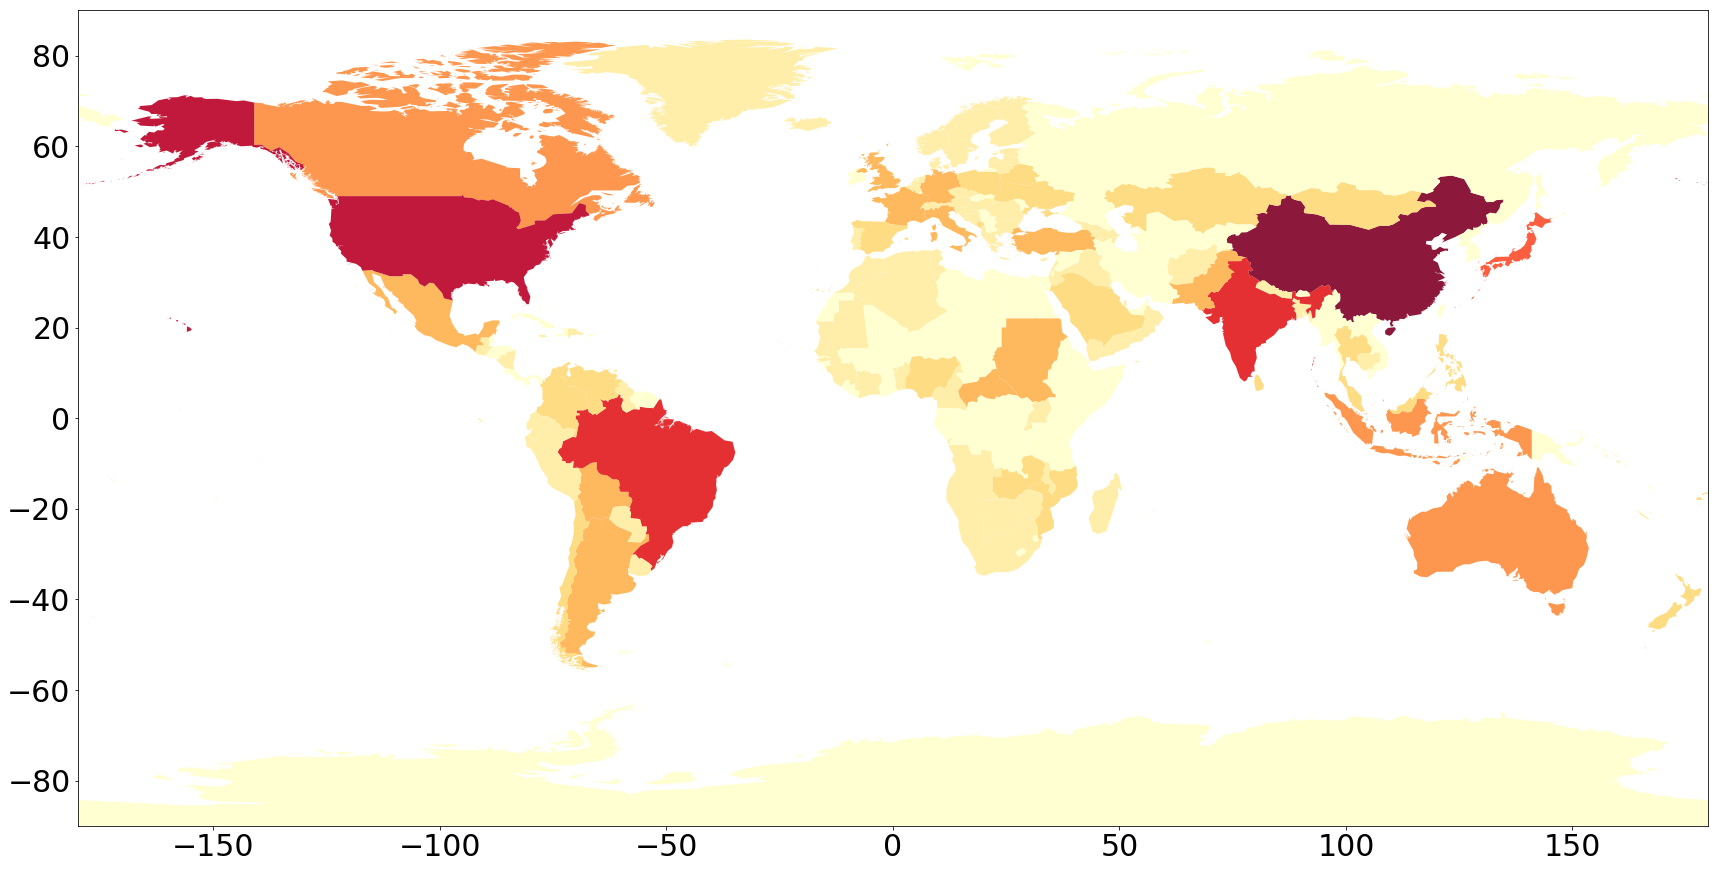

In [299]:
fig2=geo_data_merged.plot(figsize=(30,15),column='NewEmissions', scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1,
             cmap=plt.cm.YlOrRd, legend=False)
fig2.tick_params(axis='both',which='major',labelsize=30)
fig2.tick_params(axis='both',which='minor',labelsize=18)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.show(fig2)

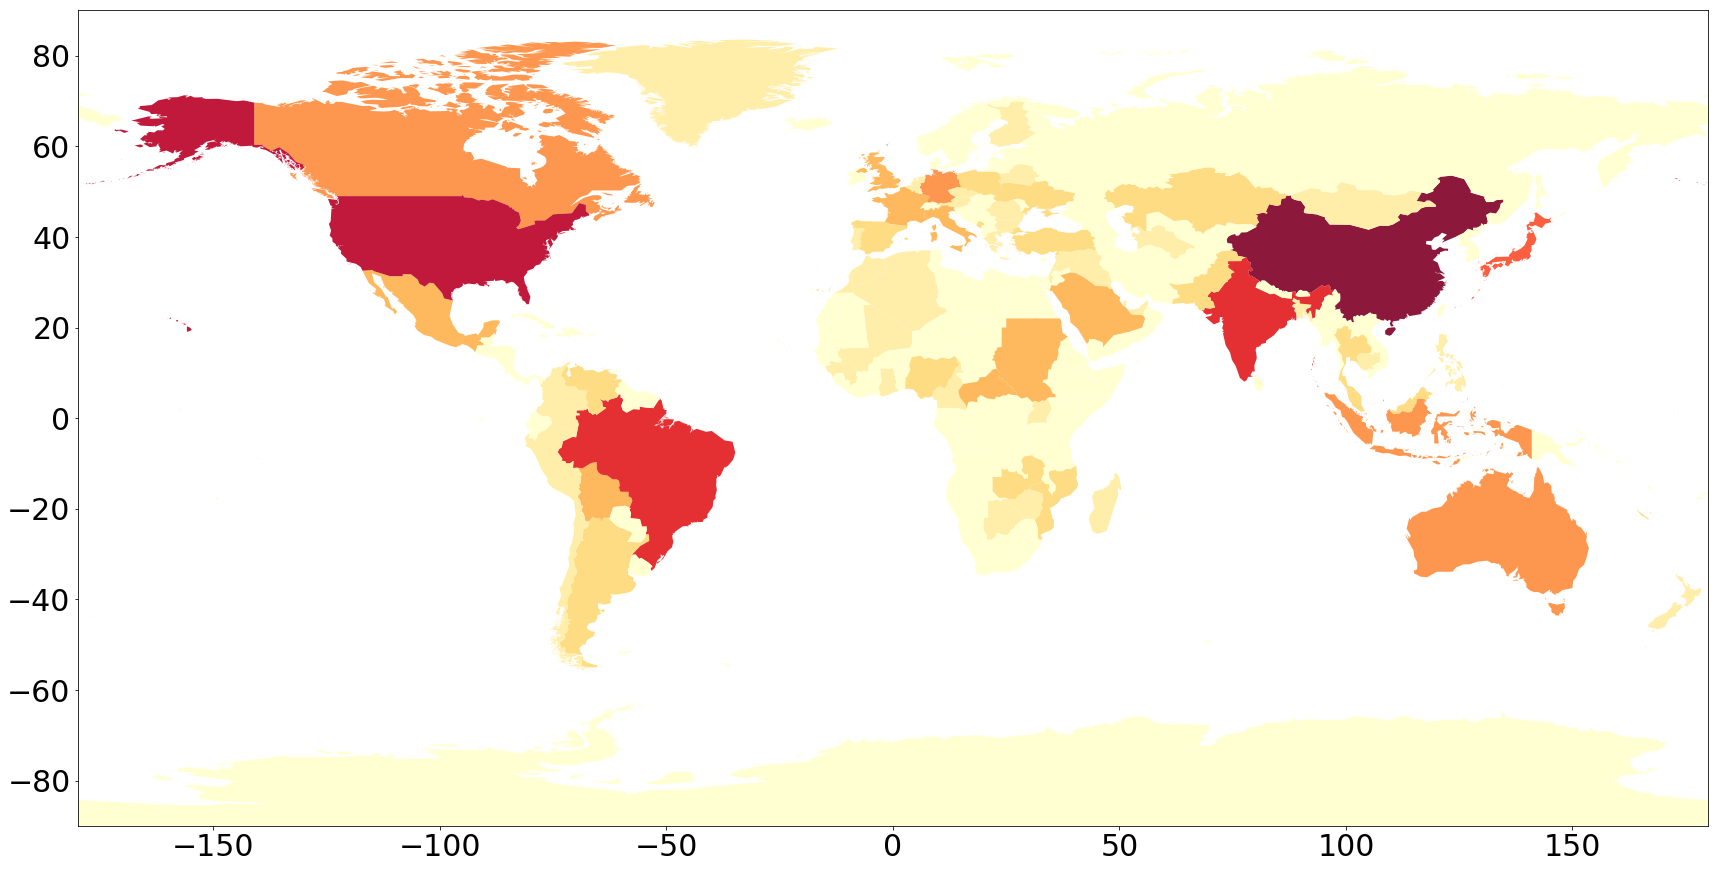

In [300]:
fig2=geo_data_merged.plot(figsize=(30,15),column='OldEmissions', scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1,
             cmap=plt.cm.YlOrRd, legend=False)
fig2.tick_params(axis='both',which='major',labelsize=30)
fig2.tick_params(axis='both',which='minor',labelsize=18)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.show(fig2)

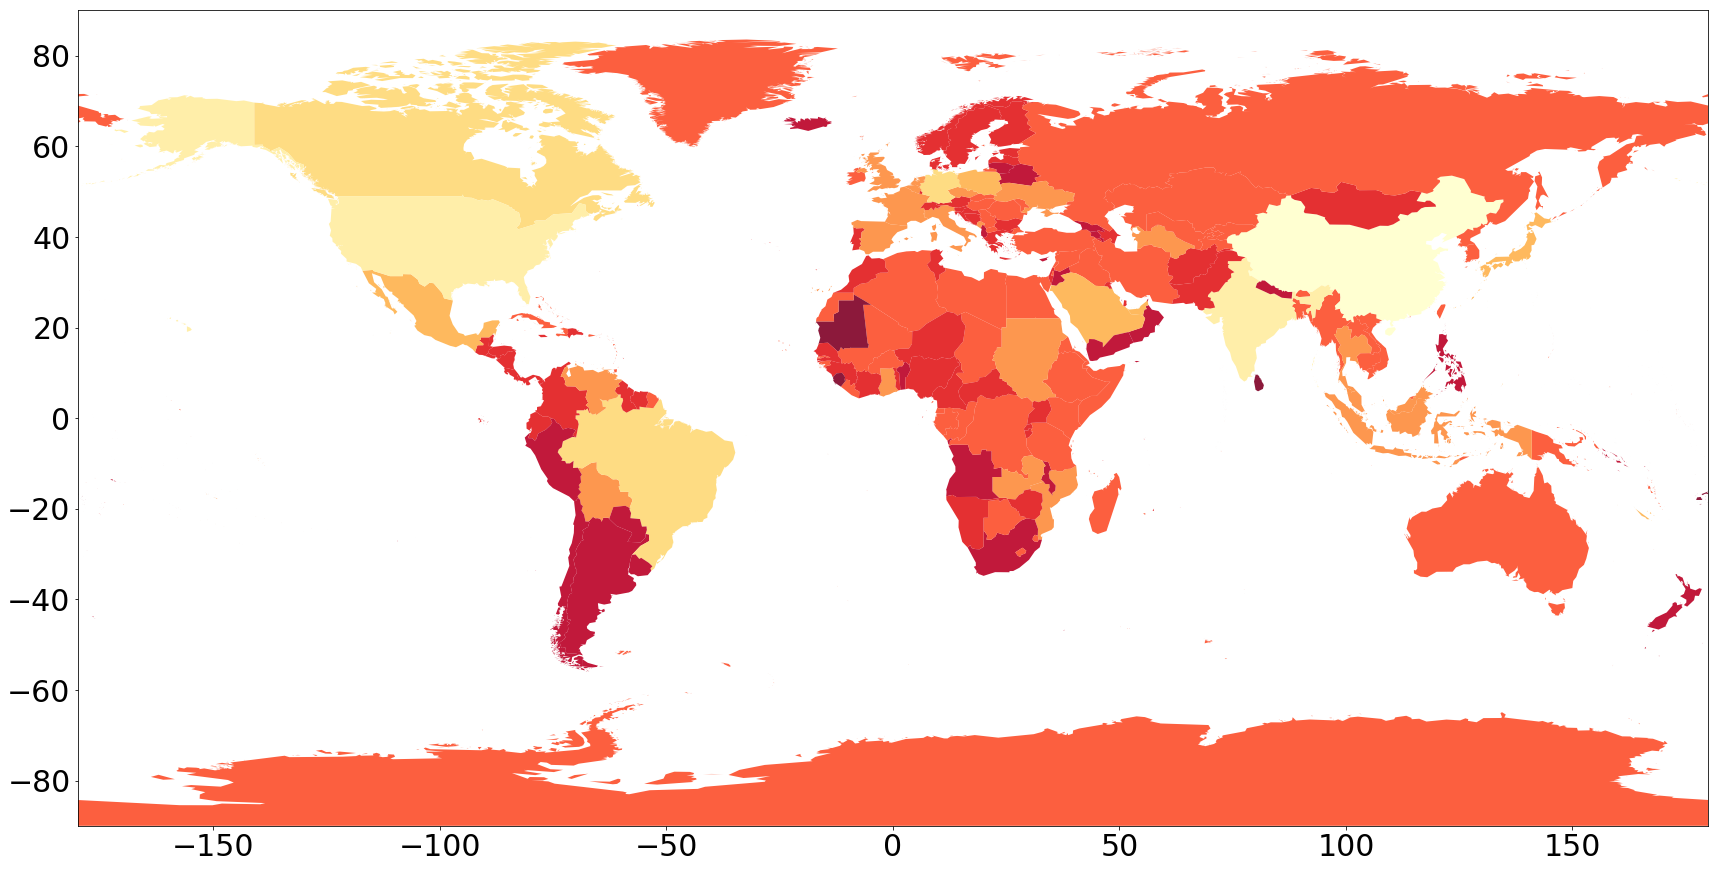

In [309]:
fig2=geo_data_merged.plot(figsize=(30,15),column='EmissionsDifference', scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1,
             cmap=plt.cm.YlOrRd, legend=False)
fig2.tick_params(axis='both',which='major',labelsize=30)
fig2.tick_params(axis='both',which='minor',labelsize=18)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.show(fig2)